In [1]:
import os, sys, pickle, glob
import numpy as np
import pandas as pd
import product_fem as pf
import fenics
import json
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Crossvalidation summary

In [2]:
basename = "rep975917"
all_xdirs = glob.glob(f"{basename}_xval_*")
result_files = glob.glob(f"{basename}_xval_*/results.pkl")
print(f"Reporting on the {len(result_files)} directories of the form {basename}_xval_* having an results.pkl file.")
if len(result_files) < len(all_xdirs):
    print(f"({len(all_xdirs) - len(result_files)} such directories do not have the result file)")

Reporting on the 72 directories of the form rep975917_xval_* having an results.pkl file.


In [3]:
configs = {}
results = {}
for x in all_xdirs:
    jf = os.path.join(x, "xval_params.json")
    rf = os.path.join(x, "results.pkl")
    if os.path.isfile(jf) and os.path.isfile(rf):
        with open(jf, 'r') as f:
            configs[x] = json.load(f)
        with open(rf, 'rb') as f:
            results[x] = pickle.load(f)
xdirs = [x for x in all_xdirs if x in results]

In [4]:
df = pd.DataFrame({
    "dir" : xdirs,
    "l2": [results[x]["params"]["regularization"]["l2"][0] for x in xdirs],
    "smoothing": [results[x]["params"]["regularization"]["smoothing"][0] for x in xdirs],
    "test_error": [np.mean([results[x][j]["test_error"] for j in range(configs[x]['folds'])]) for x in xdirs],
}).set_index("dir")
for k in ['l2err', 'l2reg', 'smreg']:
    df[k] = [np.mean([results[x][j]["losses"][k][-1] for j in range(configs[x]['folds'])]) for x in xdirs]

Here is the range of crossvalidation parameters considered (left)
and test error plotted against each of these parameters, marginally (right).

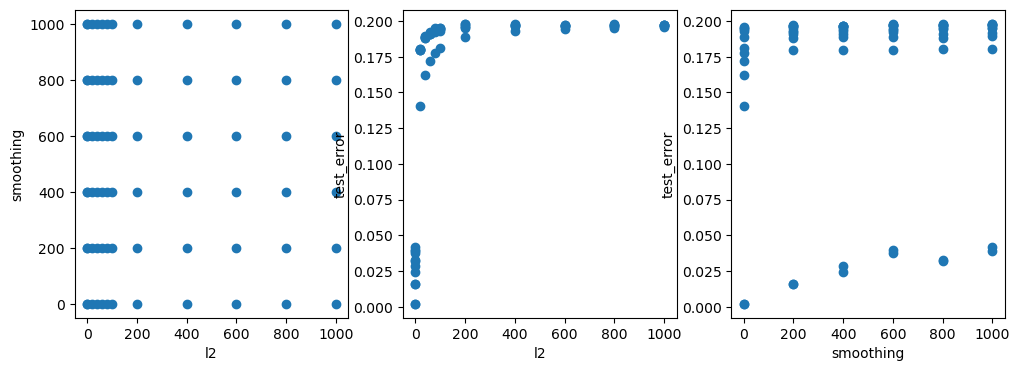

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, (j, k) in zip(axes, (('l2', 'smoothing'), ("l2", "test_error"), ("smoothing", "test_error"))):
    ax.scatter(df[j], df[k])
    ax.set_xlabel(j)
    ax.set_ylabel(k)

And, here is how various things are distributed across the range of values.
Here **test error** is the out-of-sample test error from crossvalidation;
the remaining three plots are of the three components of loss,
which are **training error**, an **L2 penalty** and a **smoothing penalty** (which is just the L2 norm of the gradient).

In [7]:
def irreg_heatmap(x, y, z, ax, label=""):
    ax.tricontour(x.to_numpy(), y.to_numpy(), z.to_numpy(),
        levels=12, linewidths=0.5, colors='k')
    cntr = ax.tricontourf(x, y, z, levels=12, cmap="RdBu_r")
    ax.plot(x, y, 'ko')
    fig.colorbar(cntr, ax=ax, label=label);

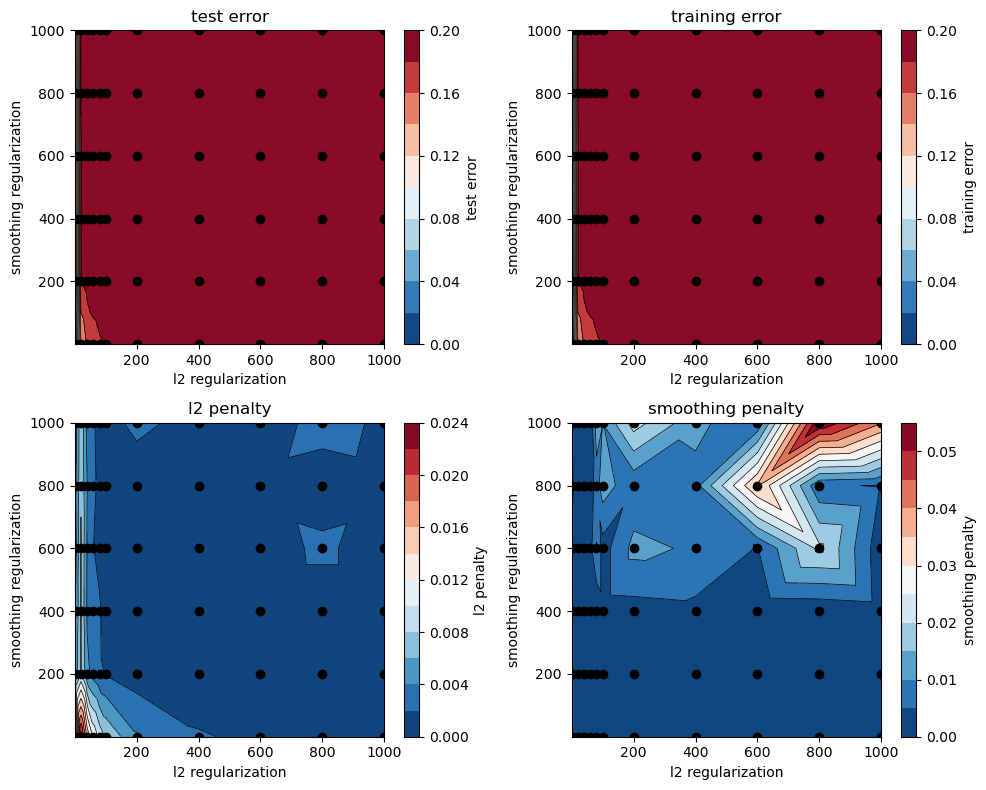

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
labels = [('test_error', "test error"), ('l2err', "training error"), ('l2reg', "l2 penalty"), ('smreg', "smoothing penalty")]
for (k, lk), ax in zip(labels, axes.flatten()):
    irreg_heatmap(df['l2'], df['smoothing'], df[k], ax, label=lk)
    ax.set_xlabel("l2 regularization"); ax.set_ylabel("smoothing regularization")
    ax.set_title(lk)
fig.tight_layout()

Okay, let's zoom in there on small values of the l2 regularization parameter:

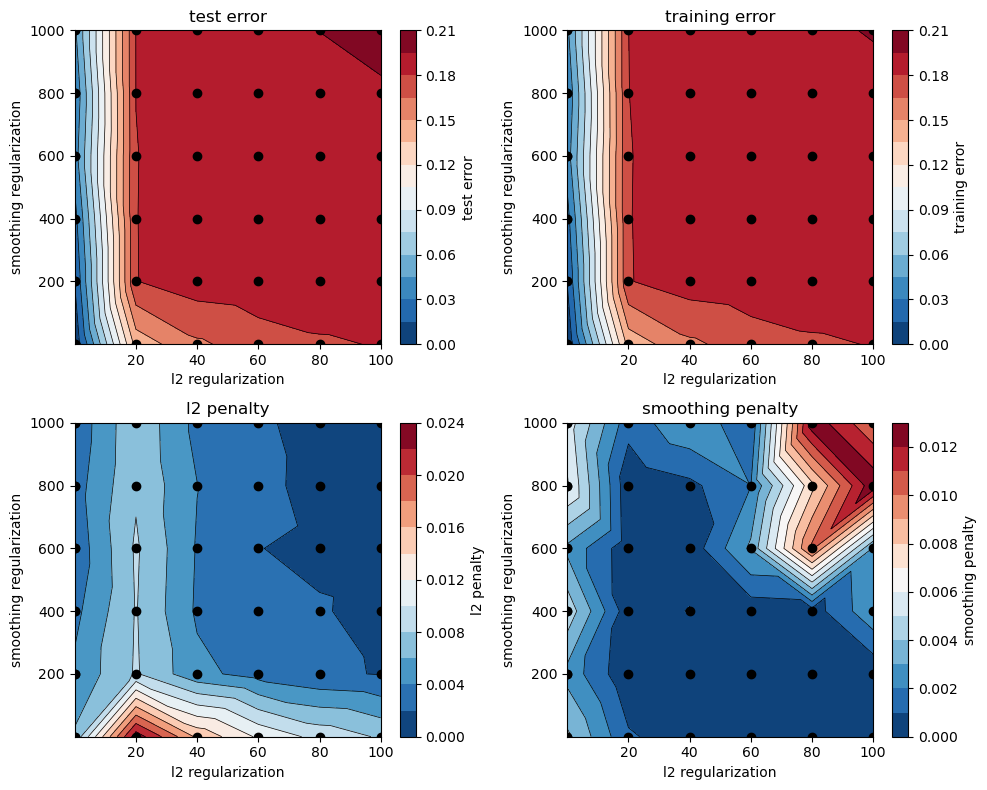

In [9]:
ut = (df['l2'] <= 100)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
labels = [('test_error', "test error"), ('l2err', "training error"), ('l2reg', "l2 penalty"), ('smreg', "smoothing penalty")]
for (k, lk), ax in zip(labels, axes.flatten()):
    irreg_heatmap(df['l2'][ut], df['smoothing'][ut], df[k][ut], ax, label=lk)
    ax.set_xlabel("l2 regularization"); ax.set_ylabel("smoothing regularization")
    ax.set_title(lk)
fig.tight_layout()